# Asalam Alaikum, Hello and welcome to this jupyter notebook

### This is some practical work from A - Z (getting data to visualizing the useful insights)

### I will get you step by step through this project to get you a better understanding of how I have done it, if you found any mistake and fault in it, feel free to comment so we can learn something together.

##### best regards

#### This project is based on books information, which I have collected this information from wikipedia website from the link below.
#### This process starts with scraping data from wikipedia (List_of_best-selling_books) page, which has some tables containing information about different type of books and other useful information about the books

### So let's get started

#### 1st: we will scrape the data from web source, so we have imported the neccessary libraries, urllib for requesting and getting the html data, and BeautifulSoup for processing the html content. Pandas for data cleaning, analyzing of the data, and numpy for some calculations

In [541]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np

#### we will request to the url

### 1: Data scraping

In [542]:
url = 'https://en.wikipedia.org/wiki/List_of_best-selling_books'
page = urlopen(url)

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
html_bytes = page.read()
html = html_bytes.decode('utf-8')

In [ ]:
start_index = html.find("<title>") + len("<title>")
end_index = html.find("</title>")
title = html[start_index:end_index]

In [ ]:
title

#### We will create an object of BeautifulSoup, and parse the html content

In [ ]:
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
soup

In [ ]:
soup.title.text

In [ ]:
len(soup.select('img'))

In [ ]:
soup.title.string

In [ ]:
soup.select('tbody')[0]

#### As you may see we can use the BeautifulSoup object to navigate through html elements so easily, and get attributes and content of the element

#### Now that we have scraped and parsed the data, the problem is that the data is so dirty. So, we should clean it first. first of all we will start getting the data from html tables and combine them and then eliminatethe \n from whole data. we will start with cleaning and chaging the data to pandas DataFrame object

### 2: Data cleaning

In [ ]:
def splitSlashN(i):
    return i.split('\n')[0]

In [ ]:
def getTableHeader(table):
    headings = []
    for th in table.tr:
        headings.append(th.text)

    try:
        while 1==1:
            headings.remove('\n')
    except:
        pass

    headings = list(map(splitSlashN, headings))
    
    return headings

#### In here we have the method to get table's data and combine the whole data because the data were fetched in many tables and we should combine all of them. columns 'No. of installments' and Genre were available in some tables, we have assigned None to records with no 'No. of installments' or Genre columns.

In [ ]:
def getTableData(table):
    table_data = []
    table_header = getTableHeader(table)

    for row in table.findAll('tr'):
        row_data = []    

        for cell in row.findAll('td'):
            row_data.append(cell.text)  

        if(len(row_data) > 0):
            data_item = {"Book": row_data[0],
                     "Author(s)": row_data[1],
                     "Original language": row_data[2]
            }
            
            i = 3;
            
            if (('No. of installments' in table_header or 'No. of instalments' in table_header) and row_data[i] != None):
                data_item['No. of installments'] = row_data[i];
                i = i + 1
            else:
                data_item['No. of installments'] = None
                
            data_item["First published"] = row_data[i] if row_data[i] != None else None
            i = i + 1
            data_item["Approximate sales"] = row_data[i] if row_data[i] != None else None
            i = i + 1
            
            try:
                if ('Genre' in table_header):
                    if (row_data[i] != None):
                        data_item["Genre"] = row_data[i]
                    else:
                        data_item['Genre'] = None
                else:
                    data_item['Genre'] = None
            except:
                data_item['Genre'] = None
            
            
            table_data.append(data_item)
                
    return table_data

In [ ]:
book_tables = soup.findAll('tbody')
book_tables.pop()
len(book_tables)

#### we will call the getTableData method to get every html table's data

In [ ]:
all_books = []

for table in book_tables:
    all_books.append(getTableData(table))

In [ ]:
all_books[7]

#### We will convert the python list (which is populated with all of the data from html table's) into pandas DataFrame

In [ ]:
books_df = pd.DataFrame()

for table in all_books:
    table = pd.DataFrame(table)
    books_df = pd.concat([books_df, table]).reset_index(drop=True)
    
books_df

#### First we will try to eliminate null rows and duplicated rows

In [ ]:
books_df.dropna(how='all', inplace=True)

In [ ]:
books_df.drop_duplicates(inplace=True)

#### We will eliminate the \n, as its visible all over the dataset 

In [ ]:
def cleanColumnsSlashN(value):
    if (value is not None):
        return value.split('\n')[0]
    
    return None

books_df['Book'] = books_df['Book'].apply(lambda x: cleanColumnsSlashN(x))
books_df['Author(s)'] = books_df['Author(s)'].apply(lambda x: cleanColumnsSlashN(x))
books_df['Original language'] = books_df['Original language'].apply(lambda x: cleanColumnsSlashN(x))
books_df['No. of installments'] = books_df['No. of installments'].apply(lambda x: cleanColumnsSlashN(x))
books_df['First published'] = books_df['First published'].apply(lambda x: cleanColumnsSlashN(x))
books_df['Approximate sales'] = books_df['Approximate sales'].apply(lambda x: cleanColumnsSlashN(x))
books_df['Genre'] = books_df['Genre'].apply(lambda x:cleanColumnsSlashN(x))

#### We will now create some useful functions to elimiate extra characters and to remain only the number in Approximate sales column so that we can work with numbers easily in analysis

In [ ]:
def getSaleAmount(sale):
    if (sale is not None):
        s = sale.split(' ')
        if (s[0][0].isdigit() or s[0][0] == '>'):
            return s[0]
        elif (s[1][0].isdigit()):
            return s[1]
        elif (s[2][0].isdigit()):
            return s[2]
        
    return None

def removeExtraCharacters(sale):
    if (sale is not None):
        s = sale.split('>')
        if (len(s) > 1):
            return s[1]
        return sale
    return None

def removeExtraBrackets(sale):
    if (sale is not None):
        s = sale.split('[')
        return s[0]
    return None

def removeDashFromSale(sale):
    if (sale is not None):
        s = sale.split('–')
        if(len(s) > 1):
            s = list([pd.to_numeric(s[0]), pd.to_numeric(s[1])])
            sales = (s[1] + s[0])/2;
            return sales
        else:
            return sale 
    return None

In [ ]:
books_df['Approximate sales'] = books_df['Approximate sales'].apply(lambda x: getSaleAmount(x)) 

In [ ]:
books_df['Approximate sales'] = books_df['Approximate sales'].apply(lambda x: removeExtraCharacters(x)) 

In [ ]:
books_df['Approximate sales'] = books_df['Approximate sales'].apply(lambda x: removeExtraBrackets(x)) 

In [ ]:
books_df['Approximate sales'] = books_df['Approximate sales'].apply(lambda x: removeDashFromSale(x)) 

In [ ]:
books_df['Approximate sales'] = pd.to_numeric(books_df['Approximate sales'])

#### Now we have eliminated the extra charaters from Approximate sales column and coverted it to numeric, but first there are some values which were in range format, so we considered to take the average value of in the range and store that

In [ ]:
books_df.loc[296]

In [ ]:
books_df.loc[300:340]

In [ ]:
books_df.describe()

#### We will create a new column as for every book it has a specific type, as you can see it in the website it self

In [ ]:
books_df['Book type'] = None

In [ ]:
books_df['Book type'].loc[0:172] = 'Individual'

In [ ]:
books_df['Book type'].loc[173:294] = 'Series'

In [ ]:
books_df['Book type'].loc[295:] = 'Regularly Updated'

In [ ]:
books_df.sample(10)

#### Its time to start working on date column, we will start with creating one more column (Last published) to cut the extra part of first published and make it easier to convert it to date, and we will take the other half of the first published and store it in newly created to column for future uses

In [ ]:
def getLastPublishing(date):
    if (date is not None):
        d = date.split('–')
        if (len(d) > 1):
            return d[1]
        
    return None

In [ ]:
books_df['Last published'] = books_df['First published'].apply(lambda x: getLastPublishing(x))

In [543]:
def getFirstPublishing(date):
    if (date is not None):
        d = date.split('–')
        return d[0]
        
    return None

In [544]:
books_df['First published'] = books_df['First published'].apply(lambda x: getFirstPublishing(x))

#### As we have polished the first published column, there is still some data which has certain value format and as there is no more then 4 records with this format so we will manualy search them and fix them

In [545]:
books_df['First published'].loc[319] = '1965'
books_df['First published'].loc[324] = '1965'

C:\Users\abwah\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [546]:
books_df[books_df['First published'].str.contains('Up to')]

,Book,Author(s),Original language,No. of installments,First published,Approximate sales,Genre,Book type,Last published


In [547]:
books_df['First published'].loc[303] = books_df['First published'].loc[303].split('(')[0]

C:\Users\abwah\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [622]:
books_df['First published'] = pd.to_datetime(books_df['First published'], errors='ignore')

#### the First published column has now the datetime type, now we can use it easily

In [549]:
books_df.sample(20)

,Book,Author(s),Original language,No. of installments,First published,Approximate sales,Genre,Book type,Last published
179,Sweet Valley High,Francine Pascal and ghostwriters,English,400,1983,250.0,N/A,Series,2003
112,All the Light We Cannot See,Anthony Doerr,English,N/A,2014,15.3,"Historical fiction, war novel",Individual,N/A
245,グイン・サーガ (Guin Saga),Kaoru Kurimoto,Japanese,147,1979,30.0,N/A,Series,2009
301,World Almanac (published every year),Various authors,English,N/A,1868,82.0,N/A,Regularly Updated,76; 1886
263,ソードアート・オンライン (Sword Art Online),Reki Kawahara,Japanese,27,2009,30.0,N/A,Series,present
262,South Beach Diet,Arthur Agatston,English,6,2003,22.0,N/A,Series,present
213,Fear Street,R. L. Stine,English,114,1989,80.0,N/A,Series,present
138,Man's Search for Meaning (Ein Psychologe erleb...,Viktor Frankl,German,N/A,1946,12.0,,Individual,N/A
69,The 7 Habits of Highly Effective People,Stephen R. Covey,English,N/A,1989,25.0,Self-help,Individual,N/A
246,徳川家康 (Tokugawa Ieyasu),Sōhachi Yamaoka,Japanese,26,1950,30.0,N/A,Series,1967


In [550]:
books_df.sample(10)

,Book,Author(s),Original language,No. of installments,First published,Approximate sales,Genre,Book type,Last published
273,スレイヤーズ (Slayers),Hajime Kanzaka,Japanese,50,1989,20.0,N/A,Series,present
89,The Happy Hooker: My Own Story,Xaviera Hollander,English,N/A,1971,20.0,Memoir,Individual,N/A
311,超図解シリーズ (Cho-Zukai series),X media,Japanese,N/A,1996,25.0,N/A,Regularly Updated,2007
110,Goodnight Moon,Margaret Wise Brown,English,N/A,1947,16.0,Children's Literature,Individual,N/A
19,Ben-Hur: A Tale of the Christ,Lew Wallace,English,N/A,1880,50.0,Historical fiction,Individual,N/A
227,The Hardy Boys,Various authors as Franklin W. Dixon,English,190,1927,50.0,N/A,Series,present
10,Harry Potter and the Chamber of Secrets,J. K. Rowling,English,N/A,1998,77.0,Fantasy,Individual,N/A
234,Harry Hole,Jo Nesbø,Norwegian,9,1997,40.0,N/A,Series,present
240,Divergent trilogy,Veronica Roth,English,3,2011,35.0,N/A,Series,2013
135,Peyton Place,Grace Metalious,English,N/A,1956,12.1,,Individual,N/A


#### Now we have a ready dataset, it may still have some errors but we will fix it when needed. some columns still have multivalues like Author (s) column, we don't need to split them as it may create redundant rows so we will keep it as it is for now, but we will split them later on if we wanted to analysis based on these multivalue columns

#### I have uploaded this dataset to kaggle, feel free to download it if you need it. the link for this dataset is below.

In [551]:
books_df.describe()

,Approximate sales
count,328.000000
mean,50.252652
std,65.021179
min,10.000000
25%,16.000000
50%,25.500000
75%,51.250000
max,567.000000


In [552]:
books_df.isnull().sum()

Book                   0
Author(s)              0
Original language      0
No. of installments    0
First published        0
Approximate sales      0
Genre                  0
Book type              0
Last published         0
dtype: int64

In [658]:
books_df = books_df.replace('', np.nan)
books_df = books_df.replace(np.nan, 'N/A') 

In [554]:
books_df.to_csv('books.csv')

#### There are some columns with some null values, but we can't fill these values as we don't have any other source to get info about this books, as they are all string values we cannot guess any suitable values for them

### 3: Data Analysis and Visualization

#### so lets get started with analysis and visualizations, we will answer some questions to get a better understanding of useful insights in our data

#### for visulization we are gonna use matplotlib and plotly

In [1085]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

#### Question 2: What books are sold the most (top 10)?

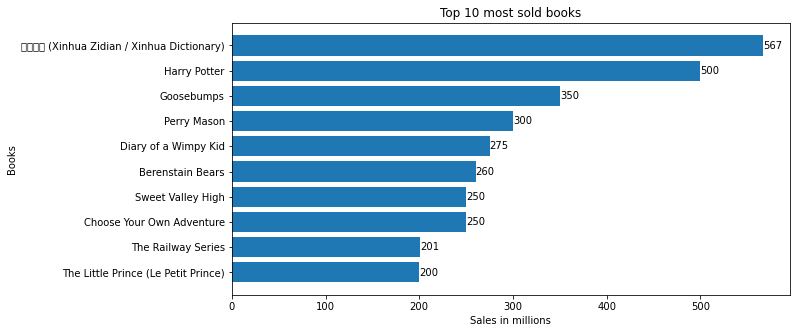

In [1091]:
most_rb = books_df.sort_values(['Approximate sales'], ascending=False).head(10).sort_values('Approximate sales')

fig, ax = plt.subplots(figsize=(10,5))
bars = ax.barh(most_rb['Book'], most_rb['Approximate sales'])
plt.ylabel('Books')
plt.xlabel('Sales in millions')
plt.bar_label(bars)
plt.title("Top 10 most sold books")
plt.show()

#### Question 1: What books are sold the most in each type (top 10)?

In [1092]:
top10individual_books = books_df[books_df['Book type'] == 'Individual'].sort_values(['Approximate sales'], ascending=False).head(10)
top10individual_books = top10individual_books.sort_values(['Approximate sales'])

top10series_books = books_df[books_df['Book type'] == 'Series'].sort_values(['Approximate sales'], ascending=False).head(10)
top10series_books = top10series_books.sort_values(['Approximate sales'])

top10regupd_books = books_df[books_df['Book type'] == 'Regularly Updated'].sort_values(['Approximate sales'], ascending=False).head(10)
top10regupd_books = top10regupd_books.sort_values(['Approximate sales'])

No handles with labels found to put in legend.
C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 32005 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 27155 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 22818 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 32005 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 27155 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 22818 missing from current font.



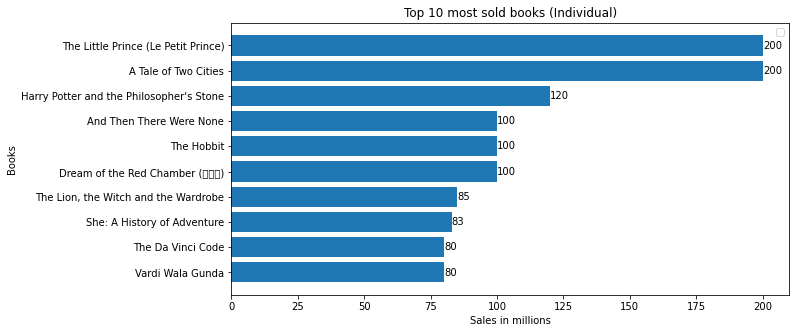

In [1093]:
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.barh(top10individual_books['Book'], top10individual_books['Approximate sales'])
plt.ylabel('Books')
plt.xlabel('Sales in millions')
plt.bar_label(bars)
plt.title("Top 10 most sold books (Individual)")
ax.legend()
plt.show()

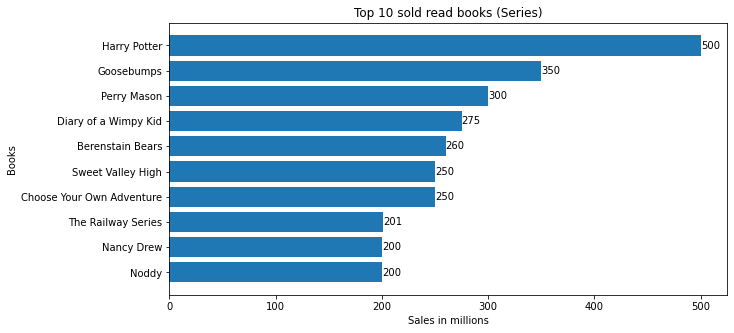

In [1094]:
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.barh(top10series_books['Book'], top10series_books['Approximate sales'])
plt.ylabel('Books')
plt.xlabel('Sales in millions')
plt.bar_label(bars)
plt.title("Top 10 sold read books (Series)")
plt.show()

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 36890 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 21213 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 20845 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 26143 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 21344 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 34899 missing from current font.

C:\Users\abwah\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 12395 missing from current font.

C:\Users\abwah\anaco

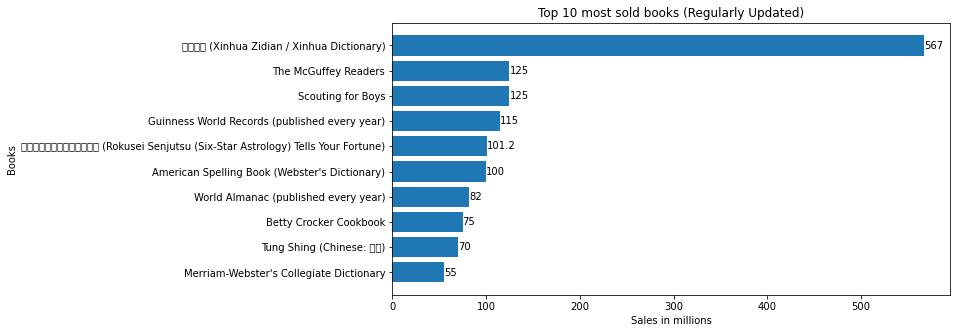

In [1095]:
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.barh(top10regupd_books['Book'], top10regupd_books['Approximate sales'])
ax.set_ylabel('Books')
ax.set_xlabel('Sales in millions')
plt.bar_label(bars)
plt.title("Top 10 most sold books (Regularly Updated)")
plt.show()

#### Question 3: Which languages has the most books sold? (percentage)

In [601]:
lang_df = books_df[['Original language','Approximate sales']].groupby('Original language').sum()
lang_df = lang_df.reset_index('Original language').sort_values(['Approximate sales'], ascending=False)

In [607]:
px.pie(lang_df, values='Approximate sales', names='Original language', title='Languages with the most books sold',                  
       color_discrete_sequence=px.colors.qualitative.Set3).show()

#### Question 4: Find the trends of different types of highest sold books from 1800 on ward?

In [614]:
typedata = books_df[['Book type', 'First published', 'Approximate sales']]
typedata.isnull().sum()

Book type            0
First published      0
Approximate sales    0
dtype: int64

In [1001]:
tydata = typedata.groupby(['First published', 'Book type']).size().reset_index(name='Total Content')
tydata = tydata.sort_values(['First published']).reset_index(drop=True)
tydata = tydata[tydata['First published'] >='1800']

In [1003]:
px.line(tydata, x='First published', y='Total Content', color='Book type', 
        title='Trends in years (Highest sold books)').show()

#### Question 5: Genres with the most sold books? (top 10)

In [1053]:
genre_df = books_df[books_df['Genre'] != 'N/A']
genre_df = genre_df[['Genre', 'Approximate sales']]

In [1054]:
genre_df['Genre'].isnull().sum()

0

In [1055]:
genre_df = genre_df.groupby('Genre').size().reset_index(name="Total publishes")

In [1056]:
genre_df = genre_df.sort_values(['Total publishes'], ascending=False).head(10).sort_values(['Total publishes'])

In [1057]:
genre_df2 = books_df[books_df['Genre'] != 'N/A']
genre_df2 = genre_df2[['Genre', 'Approximate sales']]
genre_df2 = genre_df2.groupby('Genre').sum().sort_values('Approximate sales', ascending=False).reset_index()

In [1058]:
genre_df = pd.merge(genre_df2, genre_df, on='Genre', how='right')

In [1061]:
px.bar(genre_df, x='Approximate sales', y='Genre', title='Genres total contents', color='Total publishes').show()

#### Question 6: Most successful Authors? (Top 10)

In [907]:
authors_df = books_df[books_df['Author(s)'].str.contains(',')][['Author(s)', 'Approximate sales']]

In [876]:
authors = authors_df['Author(s)'].str.split(',', expand=True).stack().to_frame()

In [877]:
authors.columns = ['Author(s)']
authors = pd.merge(authors, books_df['Author(s)'], how='outer').reset_index(drop=True)

In [878]:
authors = authors.drop(authors[authors['Author(s)'].str.contains(',')].index).reset_index(drop=True)
authors = authors.drop(authors[authors['Author(s)'] == 'N/A'].index).reset_index(drop=True)
authors = authors.drop(authors[authors['Author(s)'] == 'Various authors'].index).reset_index(drop=True)

In [879]:
authors.columns = ['Author']

In [880]:
authors = authors.groupby('Author').size().reset_index(name='Total publishes').sort_values('Total publishes', ascending=False)
authors = authors.head(20)

In [881]:
px.bar(authors.sort_values('Total publishes'), x='Total publishes', y='Author', 
       title='Most contents published of an author', color='Total publishes').show()

#### Now we will answer the same question with different method and showing the amount of sales along with it

In [888]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [933]:
authors = explode(books_df.assign(Author=books_df['Author(s)'].str.split(',')), 'Author')
authors = authors[['Author', 'Approximate sales']]
authors = authors.groupby('Author').sum().reset_index().sort_values('Approximate sales',ascending=False)

In [934]:
authors2 = explode(books_df.assign(Author=books_df['Author(s)'].str.split(',')), 'Author')
authors2 = authors2[['Author', 'Approximate sales']]
authors2 = authors2.groupby('Author').size()
authors2 = authors2.reset_index(name='Total publishes').sort_values('Total publishes',ascending=False)

In [946]:
top10authors = pd.merge(authors, authors2, how='outer').sort_values(['Approximate sales', 'Total publishes'], ascending=False)
top10authors = top10authors[top10authors['Author'] != 'Various authors']
top10authors = top10authors[top10authors['Author'] != 'N/A']
top10authors = top10authors.head(10)

In [982]:
def getName(name):
    s = name.split(":")
    if (len(s)>1):
        return s[1]
    return name

top10authors['Author'] = top10authors['Author'].apply(lambda x: getName(x))

#### Highest successful authors with approximate sales and total publishes (series and individual)

In [985]:
px.bar(top10authors.sort_values('Total publishes'), x='Total publishes', y='Author', 
       title='Most contents published of an author', color='Approximate sales').show()

#### Question 7: Which century were sold the most book? (After 18th century)

In [1080]:
typedata = books_df[['Book type', 'First published', 'Approximate sales']]
typedata.isnull().sum()
tydata = typedata.groupby(['First published', 'Book type']).sum()
tydata = tydata.sort_values(['First published']).reset_index()
tydata = tydata[tydata['First published'] >='1700']

In [1081]:
tydata['Century'] = tydata['First published'].str[0:2]

In [1082]:
tydata['Century'] = pd.to_numeric(tydata['Century'])
tydata['Century'] = tydata['Century'] + 1

In [1083]:
tydata

,First published,Book type,Approximate sales,Century
1,1783,Regularly Updated,100.0,18
2,1788,Individual,25.0,18
3,1791,Individual,100.0,18
4,1795,Regularly Updated,20.0,18
5,1813,Individual,20.0,19
...,...,...,...,...
179,2012,Individual,65.4,21
180,2014,Individual,15.3,21
181,2015,Individual,23.0,21
182,2016,Individual,10.0,21


In [1084]:
fig = px.bar(tydata, x="Century", y="Approximate sales", color="Book type", title="Best century for books")
fig.show()